In [1]:
import os
import globals as gl
import argparse
import pandas as pd
import numpy as np
from imaging_pipelines.util import extract_mle_corr
import matplotlib.pyplot as plt
import PcmPy as pcm

plt.style.use('default')

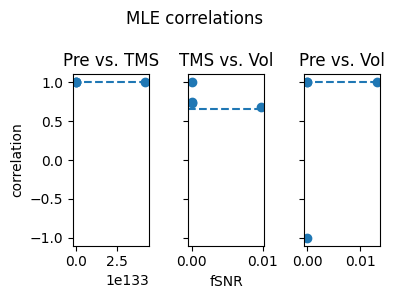

In [15]:
path = os.path.join(gl.baseDir, gl.pcmDir)
corrs = ['pre-tms', 'tms-vol', 'pre-vol',]
title = ['Pre vs. TMS', 'TMS vs. Vol', 'Pre vs. Vol', ]
fig, axs = plt.subplots(1, len(corrs), sharex=False, sharey=True, figsize=(4, 3))
for c, corr in enumerate(corrs):
    df = pd.read_csv(os.path.join(path, f'corr_{corr}.tsv'), sep='\t')
    SNR = df.SNR
    r_indiv = df.r_indiv
    r_group = df.r_group.unique()
    ax = axs[c]
    ax.scatter(SNR, r_indiv)
    ax.axhline(r_group, ls='--')
    ax.set_title(title[c])
    #ax.set_xscale('log')

axs[0].set_ylabel('correlation')
axs[0].set_ylim(-1.1, 1.1)
axs[1].set_xlabel('fSNR')
fig.suptitle('MLE correlations')
fig.tight_layout()

plt.show()

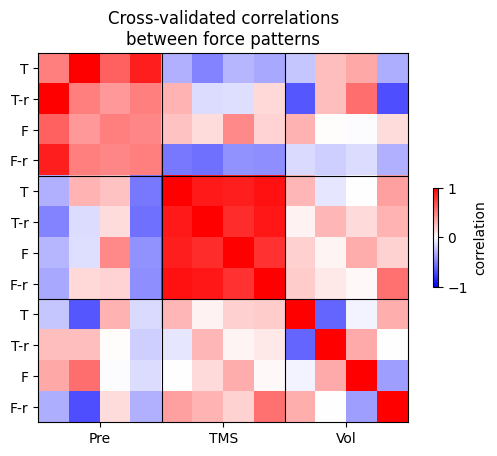

In [13]:
fig, ax = plt.subplots()

cov = np.load(os.path.join(path, f'G_obs.pre-tms-vol.npy'))
var = np.diagonal(cov, axis1=1, axis2=2)
var = np.clip(var, a_min=1e-6, a_max=np.inf)
std = np.sqrt(var)
corr = cov / (std[:, :, None] * std[:, None, :])
corr = np.clip(corr, a_min=-1, a_max=1)
ax.imshow(corr.mean(axis=0), vmin=-1, vmax=1, cmap='bwr')
ax.set_xticks([1.5, 5.5, 9.5])
ax.axhline(3.5, color='k', lw=.8)
ax.axhline(7.5, color='k', lw=.8)
ax.axvline(3.5, color='k', lw=.8)
ax.axvline(7.5, color='k', lw=.8)
ax.set_xticklabels(['Pre', 'TMS', 'Vol'])
ax.set_yticks(np.arange(12))
ax.set_yticklabels(['T', 'T-r', 'F', 'F-r'] * 3)

cax = ax.get_images()[0]
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=.01)
cbar.set_label('correlation')

ax.set_title('Cross-validated correlations\nbetween force patterns')

plt.show()

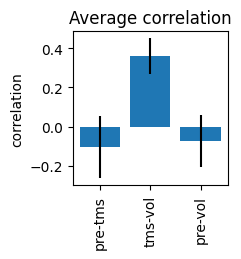

In [14]:
pre_tms = np.diagonal(corr[:, 0:4, 4:8], axis1=1, axis2=2).mean(axis=1)
tms_vol = np.diagonal(corr[:, 4:8, 8:12], axis1=1, axis2=2).mean(axis=1)
pre_vol = np.diagonal(corr[:, 0:4, 8:12], axis1=1, axis2=2).mean(axis=1)

N = corr.shape[0]

corr_avg = np.r_[pre_tms.mean(), tms_vol.mean(), pre_vol.mean()]
corr_err = np.r_[pre_tms.std() / np.sqrt(N), tms_vol.std()/ np.sqrt(N), pre_vol.std()/ np.sqrt(N)]

fig, ax = plt.subplots(figsize=(2, 2))

ax.bar(corrs, corr_avg, yerr=corr_err)
ax.set_ylabel('correlation')
ax.set_title('Average correlation')
ax.set_xticks(corrs)
ax.set_xticklabels(corrs, rotation=90)
plt.show()